In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
f = pd.read_csv('C:/Users/xavie/Downloads/UFC_data/data.csv')
f.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


**Data Preparation**

In [5]:
# Do not need red and blue data, as one impacts the other.
ufc_df = pd.DataFrame(f, columns = ['Winner', 'R_Stance',
                                 'R_Height_cms', 'R_Reach_cms',
                                 'R_Weight_lbs', 'R_age'])
ufc_df['Win'] = ufc_df['Winner']
ufc_df['Stance'] = ufc_df['R_Stance']
ufc_df['Age'] = ufc_df['R_age']

# Height and Reach: cms to m
ufc_df['Height_m'] = ufc_df['R_Height_cms'] / 100
ufc_df['Reach_m'] = ufc_df['R_Reach_cms'] / 100

# Weight: lbs to kg
ufc_df['Weight_kg'] = ufc_df['R_Weight_lbs'] * 0.453592

# Remove unwanted columns
ufc_df = ufc_df.drop(columns = ['R_Height_cms', 'R_Reach_cms', 'Winner', 
                                'R_Weight_lbs', 'R_Stance', 'R_age'])

# BMI: weight/ height^2
ufc_df['BMI'] = ufc_df['Weight_kg'] / (ufc_df['Height_m'] ** 2)

# Win column: win = 1, loss = 0, draw = 2 (will remove draw)
ufc_df['Win'] = ufc_df['Win'].replace({'Red': 1,
                                          'Blue': 0,
                                          'Draw': 2}).astype(int)
# Remove rows with draw
ufc_df = ufc_df[ufc_df.Win != 2]

# Round decimals to hundredths
ufc_df = ufc_df.round(2)

ufc_df.head()

,Win,Stance,Age,Height_m,Reach_m,Weight_kg,BMI
0,1,Orthodox,32.0,1.63,1.63,61.23,23.17
1,1,Southpaw,31.0,1.65,1.68,56.70,20.80
2,1,Orthodox,35.0,1.80,1.93,70.31,21.62
3,0,Orthodox,29.0,1.63,1.73,61.23,23.17
4,0,Southpaw,26.0,1.88,1.90,119.75,33.90


**Pipelining the Data Prep**

In [6]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical_feature = ['Stance']
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

numerical_features = ['Height_m', 'Reach_m', 'Weight_kg', 'Age', 'BMI']
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean'))
])

preprocessor = ColumnTransformer(
                    transformers = [
                        ('cat', categorical_transformer, categorical_feature),
                        ('num', numerical_transformer, numerical_features)
                    ])

**Evaluate Predictions**

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs y_preds labels
    on a classification model.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {'accuracy': round(accuracy, 2),
                   'precision': round(precision, 2),
                   'recall': round(recall, 2),
                   'f1': round(f1, 2)}
    print(f'Acc: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 score: {f1:.2f}')
    
    return metric_dict

**Modeling Data**

In [9]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(42)

model = Pipeline(steps = [('preprocessor', preprocessor),
                          ('scaler', StandardScaler()),
                          ('model', SVC())])

X = ufc_df.drop('Win', axis = 1)
y = ufc_df['Win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
baseline_metrics = evaluate_preds(y_test, y_preds)

Acc: 67.52%
Precision: 0.67
Recall: 1.00
F1 score: 0.80


**Improve Model by Hyperparameters**

In [20]:
# Randomized Search CV before Grid Search CV
from sklearn.model_selection import RandomizedSearchCV

# Set up parameter grid
rs_pipe_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'model__max_iter': [1000, 10000],
    'model__kernel': ['linear', 'poly', 'rbf'],
    'model__gamma': [1, 0.1, 0.01, 0.001],
    'model__C': [0.1, 1, 10, 50, 100],
    'model__degree': [1, 2, 3, 4 , 5]
}

# Instantiate SVM
rs_svc = RandomizedSearchCV(estimator = model, 
                            param_distributions = rs_pipe_grid,
                            n_iter = 10, 
                            cv = 5,
                            verbose = 2,
                            random_state = 42,
                            refit = True)
rs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100, total=   1.0s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.1, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50, total=   0.4s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50, total=   0.4s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50, total=   0.4s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50, total=   0.5s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=rbf, model__gamma=0.001, model__degree=3, model__C=50, total=   0.5s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100, total=   0.8s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100, total=   0.8s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100, total=   0.8s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=linear, model__gamma=0.01, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100, total=   1.0s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100, total=   0.7s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100, total=   0.7s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100, total=   0.7s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=linear, model__gamma=0.001, model__degree=3, model__C=100, total=   0.7s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100 
[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100, total=   0.1s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100, total=   0.1s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100 
[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100, total=   0.1s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100, total=   0.1s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100 
[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=1000, model__kernel=linear, model__gamma=0.001, model__degree=2, model__C=100, total=   0.1s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1, total=   0.3s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1, total=   0.3s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1, total=   0.3s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1, total=   0.3s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=1000, model__kernel=linear, model__gamma=0.01, model__degree=3, model__C=0.1, total=   0.3s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.01, model__degree=5, model__C=1 
[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.01, model__degree=5, model__C=1, total=   0.6s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.01, model__degree=5, model__C=1 
[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.01, model__degree=5, model__C=1, total=   0.6s
[CV] preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.01, model__degree=5, model__C=1 
[CV]  preprocessor__num__imputer__strategy=mean, model__max_iter=10000, model__kernel=rbf, model__gamma=0.01, model__degr

C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100, total=   0.8s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100, total=   0.9s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100, total=   0.8s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100, total=   0.8s
[CV] preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100 


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.4s finished


[CV]  preprocessor__num__imputer__strategy=median, model__max_iter=10000, model__kernel=poly, model__gamma=0.1, model__degree=4, model__C=100, total=   0.8s


C:\Users\xavie\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('cat',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                     

In [22]:
rs_svc.best_params_

{'preprocessor__num__imputer__strategy': 'median',
 'model__max_iter': 1000,
 'model__kernel': 'linear',
 'model__gamma': 0.01,
 'model__degree': 3,
 'model__C': 0.1}

In [23]:
# Evaluate Randomized Search model
rs_y_preds = rs_svc.predict(X_test)

# Evaluate the classifier on validation set
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 68.02%
Precision: 0.68
Recall: 0.97
F1 score: 0.80


In [24]:
from sklearn.model_selection import GridSearchCV

gs_pipe_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['auto', 'scale', 0.01],
    'model__C': [0.1, 1, 10],
    'model__degree': [3, 4 , 5]
}

gs_svc = GridSearchCV(estimator = model,
                      param_grid = gs_pipe_grid,
                      cv = 5,
                      verbose = 2,
                      refit = True)

gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.3s
[CV] model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=0.1, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__impu

[CV]  model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.8s
[CV] model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.8s
[CV] model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.7s
[CV] model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.7s
[CV] model__C=0.1, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer_

[CV]  model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.3s
[CV] model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.3s
[CV] model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.4s
[CV] model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.6s
[CV] model__C=0.1, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imp

[CV]  model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.3s
[CV] model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.3s
[CV] model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.3s
[CV] model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.3s
[CV] model__C=0.1, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__impu

[CV]  model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.8s
[CV] model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.8s
[CV] model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.8s
[CV] model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.8s
[CV] model__C=0.1, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=me

[CV]  model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.3s
[CV] model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.3s
[CV] model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.3s
[CV] model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.4s
[CV] model__C=0.1, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor

[CV]  model__C=1, model__degree=3, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.9s
[CV] model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=1, model__degree=3, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strat

[CV]  model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.8s
[CV] model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.7s
[CV] model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.7s
[CV] model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.8s
[CV] model__C=1, model__degree=3, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C

[CV]  model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.4s
[CV] model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.4s
[CV] model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.4s
[CV] model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.4s
[CV] model__C=1, model__degree=4, model__gamma=scale, model__kernel=linear, preprocessor__num

[CV]  model__C=1, model__degree=4, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.6s
[CV] model__C=1, model__degree=4, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=1, model__degree=4, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   0.6s
[CV] model__C=1, model__degree=5, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=5, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=1, model__degree=5, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=5, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.4s
[CV] model__C=1, model__degree=5, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean 

[CV]  model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.8s
[CV] model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.8s
[CV] model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.7s
[CV] model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   0.9s
[CV] model__C=1, model__degree=5, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  mode

[CV]  model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.6s
[CV] model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.6s
[CV] model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.6s
[CV] model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.6s
[CV] model__C=10, model__degree=3, model__gamma=auto, model__kernel=linear, preprocessor__num__

[CV]  model__C=10, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.2s
[CV] model__C=10, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.2s
[CV] model__C=10, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=3, model__gamma=scale, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.2s
[CV] model__C=10, model__degree=3, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=3, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.6s
[CV] model__C=10, model__degree=3, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__str

[CV]  model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.1s
[CV] model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.2s
[CV] model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.2s
[CV] model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.1s
[CV] model__C=10, model__degree=4, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model_

[CV]  model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=  16.4s
[CV] model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=mean, total=   0.7s
[CV] model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.7s
[CV] model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.8s
[CV] model__C=10, model__degree=4, model__gamma=0.01, model__kernel=linear, preprocessor__num__impu

[CV]  model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.4s
[CV] model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.2s
[CV] model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.2s
[CV] model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median 
[CV]  model__C=10, model__degree=5, model__gamma=auto, model__kernel=rbf, preprocessor__num__imputer__strategy=median, total=   1.2s
[CV] model__C=10, model__degree=5, model__gamma=scale, model__kernel=linear, preprocessor__num__imputer__strategy=

[CV]  model__C=10, model__degree=5, model__gamma=0.01, model__kernel=linear, preprocessor__num__imputer__strategy=median, total=   0.6s
[CV] model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.4s
[CV] model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.3s
[CV] model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean, total=   1.7s
[CV] model__C=10, model__degree=5, model__gamma=0.01, model__kernel=rbf, preprocessor__num__imputer__strategy=mean 
[CV]  m

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [25]:
gs_svc.best_params_

{'model__C': 0.1,
 'model__degree': 3,
 'model__gamma': 'auto',
 'model__kernel': 'linear',
 'preprocessor__num__imputer__strategy': 'mean'}

In [27]:
gs_y_preds = gs_svc.predict(X_test)

gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 67.13%
Precision: 0.67
Recall: 1.00
F1 score: 0.80


**Compare Metrics**

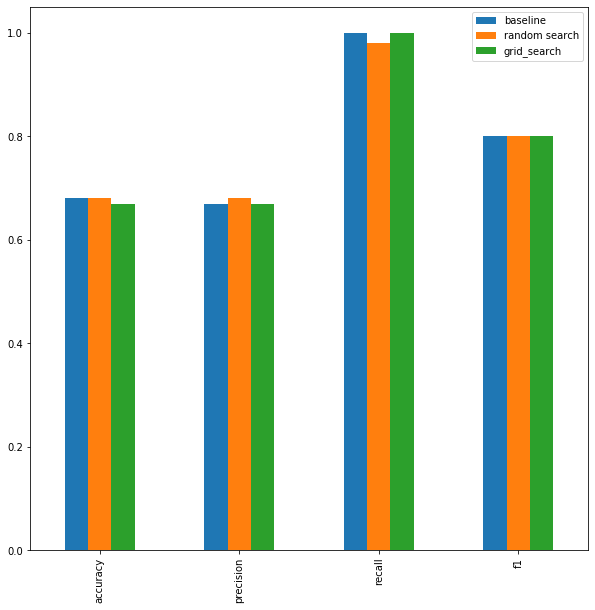

In [28]:
# Comparing all the metrics of the models
compare_metrics = pd.DataFrame({'baseline': baseline_metrics,
                                'random search': rs_metrics,
                                'grid_search': gs_metrics})

compare_metrics.plot.bar(figsize = (10, 10));

**Big Mistake to never do again**

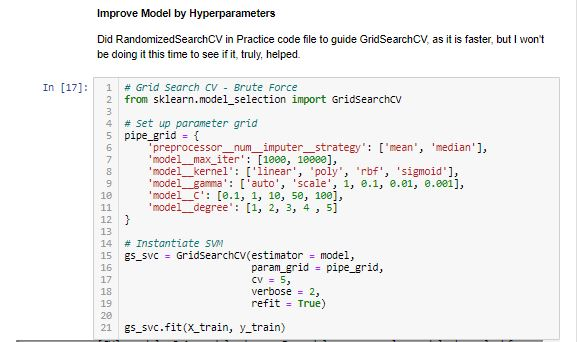
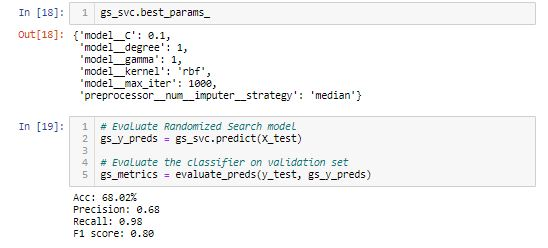

Same as the Randomized Search CV model, besides the .01% difference in precision.

**Save and Load Model (Model Transportation)**

Using Pickle instead of Joblib because there aren't a lot of samples of data.

In [34]:
import pickle

# Save an existing model to the file
pickle.dump(rs_svc, open('rs_svc_module.pkl', 'wb'))

In [35]:
# Load a saved model
loaded_pickle_model = pickle.load(open('rs_svc_module.pkl', 'rb'))

In [36]:
# Check if model is loaded: Make some predictions
pickle_y_preds = loaded_pickle_model.predict(X_test)
evaluate_preds(y_test, pickle_y_preds)

Acc: 68.02%
Precision: 0.68
Recall: 0.97
F1 score: 0.80


{'accuracy': 0.68, 'precision': 0.68, 'recall': 0.98, 'f1': 0.8}

**Make Predictions**

Also see which feature has the most correlation to the label for a better idea of how the model predicts new data.

In [76]:
cor = ufc_df.corr().abs()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))
# Feature with correlation greater than 0.7
high_corr = [column for column in upper.columns if any(upper[column] > 0.70)]
print(high_corr, '\n', upper)

['Reach_m', 'Weight_kg', 'BMI'] 
            Win       Age  Height_m   Reach_m  Weight_kg       BMI
Win        NaN  0.161882  0.074239  0.066894   0.111137  0.113225
Age        NaN       NaN  0.074404  0.075055   0.186072  0.222181
Height_m   NaN       NaN       NaN  0.889551   0.780982  0.463369
Reach_m    NaN       NaN       NaN       NaN   0.762441  0.499848
Weight_kg  NaN       NaN       NaN       NaN        NaN  0.911960
BMI        NaN       NaN       NaN       NaN        NaN       NaN


In [86]:
ufc_df[:1]

,Win,Stance,Age,Height_m,Reach_m,Weight_kg,BMI
0,1,Orthodox,32.0,1.63,1.63,61.23,23.17


In [174]:
# Defining one new instance
Xnew = pd.DataFrame([['Orthodox', 22.5, 1.60, 1.68, 72.57, 28.35]],
                    columns = ['Stance', 'Age', 'Height_m',
                               'Reach_m', 'Weight_kg', 'BMI'],
                    dtype = float)
# Make a prediction
print(model.predict(Xnew), rs_svc.predict(Xnew), gs_svc.predict(Xnew))

[1] [1] [1]
